# **Task 4: Modality Gap in CLIP**

## **1. Zero-Shot Classification on STL-10**

In [9]:
!pip install git+https://github.com/openai/CLIP.git
!pip install ftfy regex tqdm

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-quxlom82
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-quxlom82
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [10]:
# a) donwload the DTL-10 dataset from torchvision datasets

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import clip
import numpy as np
from tqdm import tqdm

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model, preprocess = clip.load("ViT-B/32", device=device)
print("Model loaded successfully.")


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                        std=[0.26862954, 0.26130258, 0.27577711])  # CLIP normalization
])


# download the dataset
train_dataset = torchvision.datasets.STL10(
    root='./data',
    split='train',
    download=True,
    transform=transform,
)
# create dataloaders
test_dataset = torchvision.datasets.STL10(
    root='./data',
    split = 'test',
    download=True,
     transform=transform,
)
# test_loader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


# Stl class names
class_names = test_dataset.classes
print("Class names:", class_names)


Using device: cpu
Model loaded successfully.
Class names: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [11]:
# b) load openai's clip model
import clip

# load the model
print("Loading CLIP model...")
model, preprocess = clip.load("ViT-B/32", device=device)

print(f"Model loaded successfully.")


Loading CLIP model...
Model loaded successfully.


In [5]:
# c) evaluate CLIP for zero-short accuracy using diffeerent prompts

def evaluate_clip_zeroshot(model, dataloader, text_prompts,  class_names):
    model.eval()

    # tokanize the text prompts
    text_tokens = clip.tokenize(text_prompts).to(device)

    # get the features
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    correct = 0
    total = 0

    # get text features
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating "):
            images = images.to(device)


            # get the features
            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

            # compute similarity
            similarity = (100.0 * image_features @ text_features.T)

            # get the predictions
            _, predictions = similarity.max(dim=1)

            correct += (predictions == labels.to(device)).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    return accuracy

# plain labels
print("\n" + "="*60)
print("EXPERIMENT 1: Plain Labels")
print("="*60)


prompts_plain = class_names # e.g., "airplane", "bird"
accuracy_plain = evaluate_clip_zeroshot(model, test_loader, prompts_plain, class_names)
print(f"Accuracy: {accuracy_plain:.2f}%")

# simple promts
print("\n" + "="*60)
print("EXPERIMENT 2: Simple Template")
print("="*60)

prompts_simple = [f"a photo of a {name}" for name in class_names]

accuracy_simple = evaluate_clip_zeroshot(model, test_loader, prompts_simple, class_names)
print(f"Accuracy: {accuracy_simple:.2f}%")

# descriptive prompts
print("\n" + "="*60)
print("EXPERIMENT 3: Descriptive Prompts")
print("="*60)

# Create descriptive prompts for each class
descriptive_map = {
    'airplane': "a photo of an airplane, a flying vehicle",
    'bird': "a photo of a bird, a flying animal",
    'car': "a photo of a car, a road vehicle",
    'cat': "a photo of a cat, a small furry animal",
    'deer': "a photo of a deer, a wild animal with antlers",
    'dog': "a photo of a dog, a domesticated pet animal",
    'horse': "a photo of a horse, a large domesticated animal",
    'monkey': "a photo of a monkey, a primate animal",
    'ship': "a photo of a ship, a water vessel",
    'truck': "a photo of a truck, a large road vehicle"
}

prompts_desc = [descriptive_map[name] for name in class_names]
print(f"Prompts: {prompts_desc[:3]}...")

accuracy_desc = evaluate_clip_zeroshot(model, test_loader, prompts_desc, class_names)
print(f"Accuracy: {accuracy_desc:.2f}%")


EXPERIMENT 1: Plain Labels


Evaluating : 100%|██████████| 125/125 [19:47<00:00,  9.50s/it]


Accuracy: 95.99%

EXPERIMENT 2: Simple Template


Evaluating : 100%|██████████| 125/125 [19:34<00:00,  9.40s/it]


Accuracy: 97.26%

EXPERIMENT 3: Descriptive Prompts
Prompts: ['a photo of an airplane, a flying vehicle', 'a photo of a bird, a flying animal', 'a photo of a car, a road vehicle']...


Evaluating : 100%|██████████| 125/125 [19:33<00:00,  9.39s/it]

Accuracy: 95.62%


Strategy                  Accuracy        Difference from Plain
----------------------------------------------------------------------
Plain Labels               95.99%          +0.00%
Simple Template            97.26%          +1.28%
Descriptive                95.62%          -0.36%

Saved: clip_prompting_comparison.png


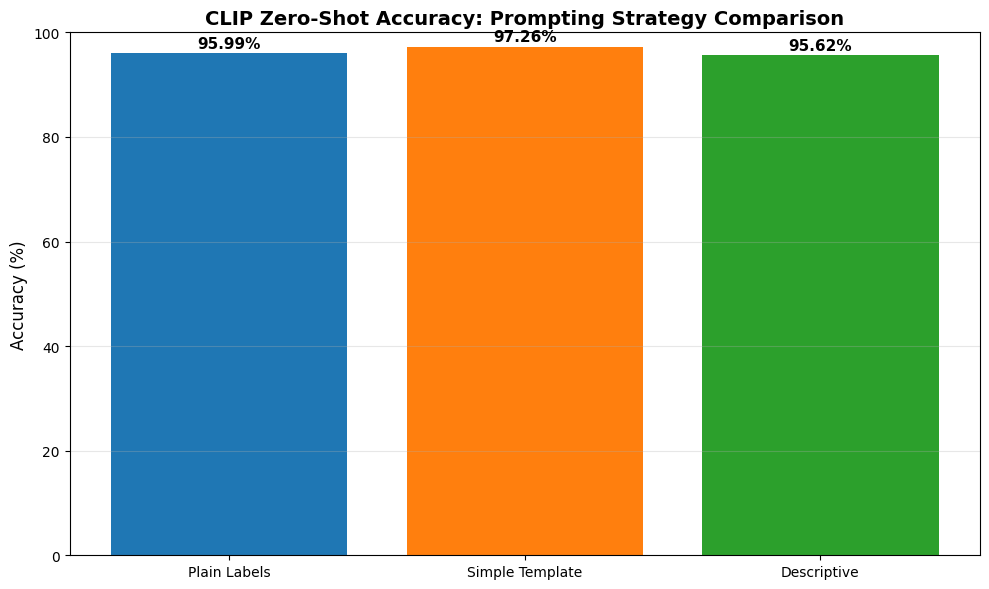


Key Observation:
Best strategy: Simple Template with 97.26% accuracy


In [12]:

# d) plot the results
results = {
    "Plain Labels": accuracy_plain,
    "Simple Template": accuracy_simple,
    "Descriptive": accuracy_desc
}

print(f"{'Strategy':<25} {'Accuracy':<15} {'Difference from Plain':<20}")
print("-" * 70)
for strategy, acc in results.items():
    diff = acc - accuracy_plain
    print(f"{strategy:<25} {acc:>6.2f}%         {diff:>+6.2f}%")
print("="*70)

# Visualize comparison
import matplotlib.pyplot as plt

strategies = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(strategies, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('CLIP Zero-Shot Accuracy: Prompting Strategy Comparison',
          fontsize=14, fontweight='bold')
plt.ylim([0, 100])

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc:.2f}%', ha='center', fontsize=11, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('clip_prompting_comparison.png', dpi=300, bbox_inches='tight')
print("\nSaved: clip_prompting_comparison.png")
plt.show()

print("\nKey Observation:")
best_strategy = max(results, key=results.get)
print(f"Best strategy: {best_strategy} with {results[best_strategy]:.2f}% accuracy")

# **2. Exploring Modality Gap**

In [17]:
# a). extract image and labels from dataset

def extract_clip_embeddings(model, dataloader, num_samples=100):
    model.eval()

    # extract text embeddings
    print("Extracting text embeddings...")
    text_promts = [f"a photo of a {label}" for label in dataloader.dataset.classes]
    text_tokens = clip.tokenize(text_promts).to(device)

    with torch.no_grad():
        text_embeddings = model.encode_text(text_tokens)
        text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

    text_embeddings = text_embeddings.cpu().numpy()

    #extract image embeddings
    print(f"Extracting image embeddings for {num_samples} samples...")
    image_embeddings = []
    image_labels = []

    count = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting"):
            if count >= num_samples:
                break

            images = images.to(device)

            # get image features
            img_features = model.encode_image(images)
            img_features = img_features / img_features.norm(dim=-1, keepdim=True)

            image_embeddings.append(img_features.cpu().numpy())
            image_labels.append(labels.numpy())

            count += images.size(0)

    image_embeddings = np.vstack(image_embeddings)[:num_samples]
    image_labels = np.concatenate(image_labels)[:num_samples]

    print(f"Extracted {image_embeddings.shape[0]} image embeddings")
    print(f"Image embedding shape: {image_embeddings.shape}")
    print(f"Text embedding shape: {text_embeddings.shape}")

    return image_embeddings, text_embeddings, image_labels


# extract embeddings
image_embeddings, text_embeddings, labels = extract_clip_embeddings(
    model,
    test_loader,
    num_samples=100
)

Extracting text embeddings...
Extracting image embeddings for 100 samples...


Extracting:   2%|▏         | 2/125 [00:25<26:17, 12.83s/it]

Extracted 100 image embeddings
Image embedding shape: (100, 512)
Text embedding shape: (10, 512)


In [15]:
# b) use UMAP or T-SNE to project embeddings into 2D
from sklearn.manifold import TSNE
import umap

def reduce_dimensionality(image_embeddings, text_embeddings, method='umap'):

    # combine embeddings
    combined_embeddings = np.vstack([image_embeddings, text_embeddings])

    print(f"\nReducing to 2D using {method.upper()}...")

    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    else:  # umap
        reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15)

    combined_2d = reducer.fit_transform(combined_embeddings)

    # split back into image and text
    n_images = len(image_embeddings)
    image_2d = combined_2d[:n_images]
    text_2d = combined_2d[n_images:]

    print(f"Dimensionality reduction complete")

    return image_2d, text_2d


# reduce to 2D using UMAP
image_2d_umap, text_2d_umap = reduce_dimensionality(
    image_embeddings, text_embeddings, method='umap'
)

# reduce to 2D using T-SNE
image_2d_tsne, text_2d_tsne = reduce_dimensionality(
    image_embeddings, text_embeddings, method='tsne'
)



Reducing to 2D using UMAP...
Dimensionality reduction complete

Reducing to 2D using TSNE...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Dimensionality reduction complete


Saved: modality_gap_umap.png


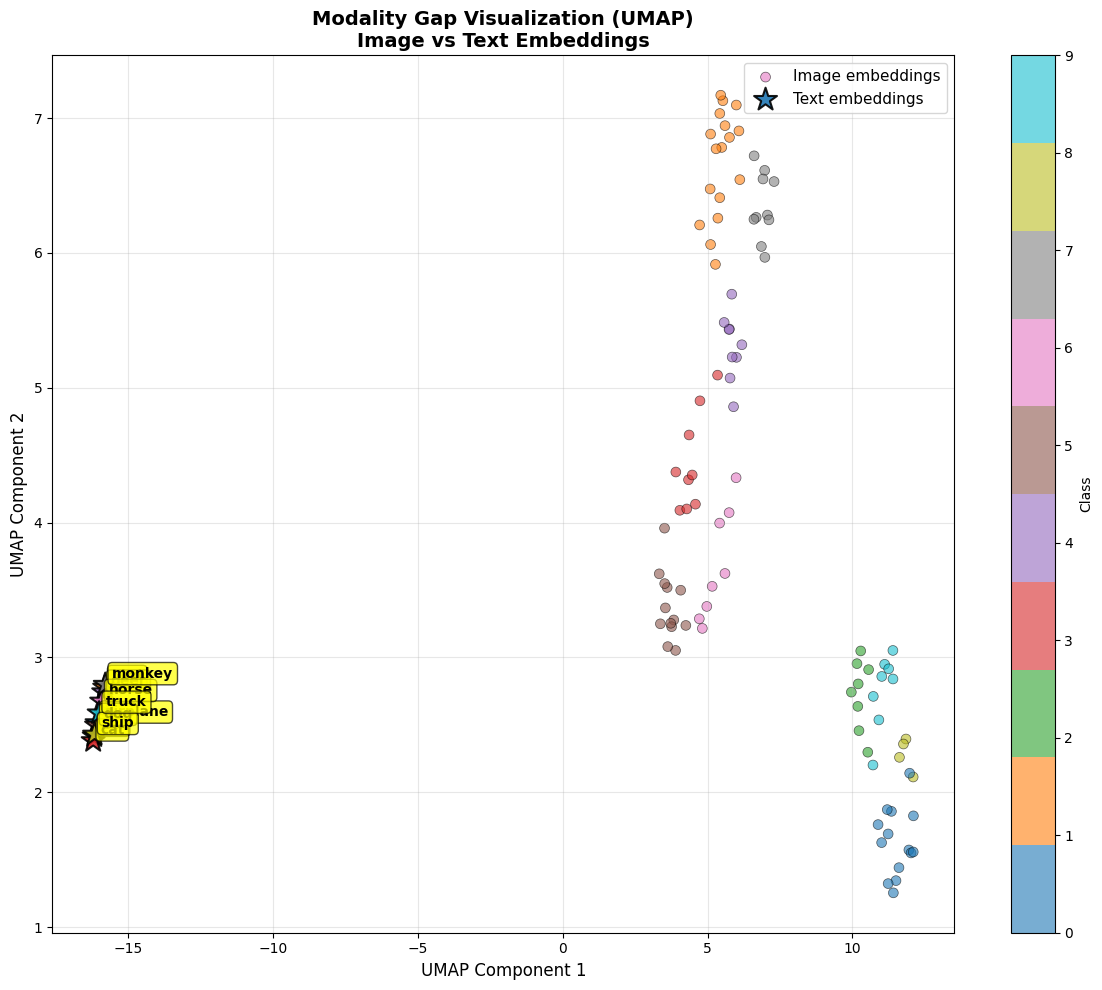

Saved: modality_gap_t-sne.png


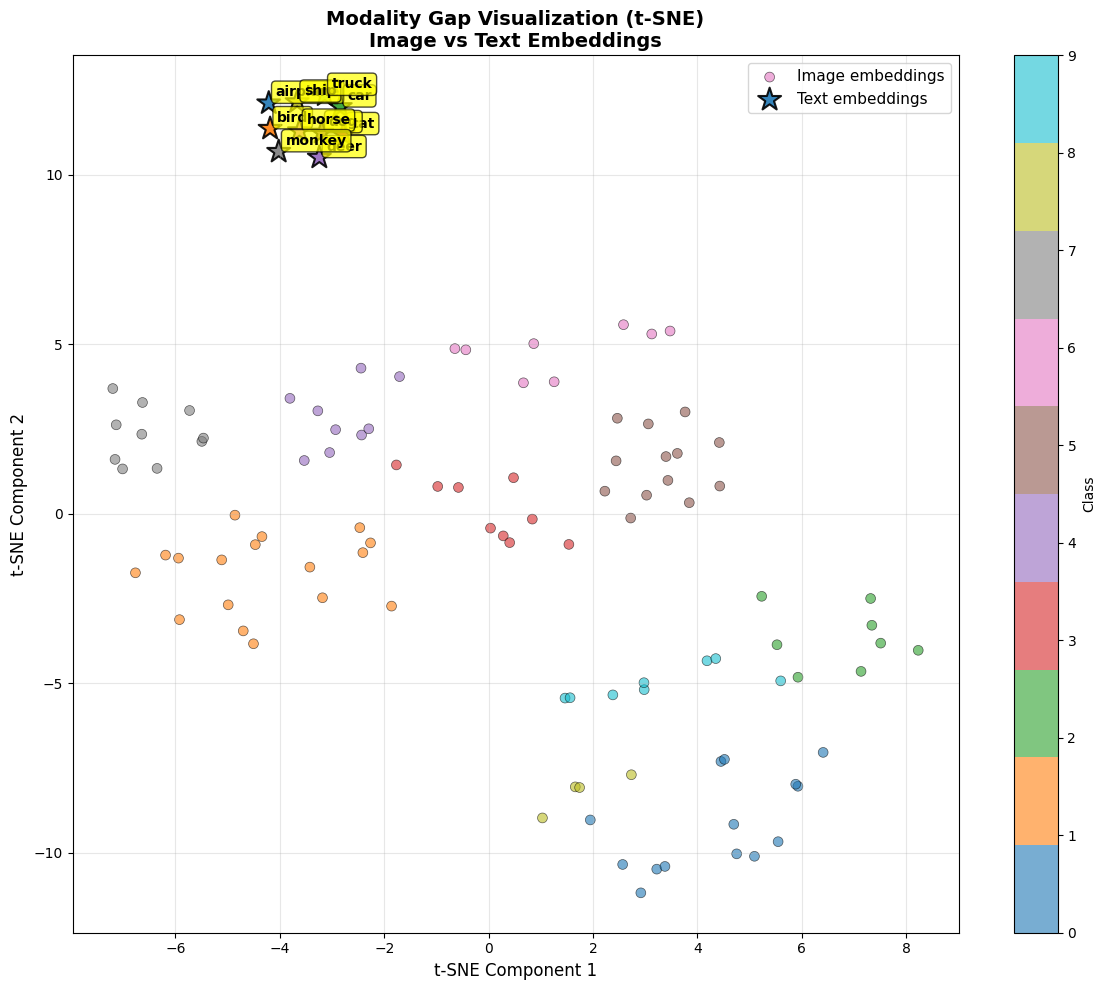

In [16]:
# c). Visuaize and compare distributions of text and image embeddings
def visualize_modality_gap(image_2d, text_2d, labels, class_names, method='UMAP'):

    plt.figure(figsize=(12, 10))

    # plot image embeddings
    scatter_img = plt.scatter(image_2d[:, 0], image_2d[:, 1],
                              c=labels, cmap='tab10',
                              s=50, alpha=0.6, marker='o',
                              label='Image embeddings', edgecolors='black', linewidths=0.5)

    # plot text embeddings
    scatter_text = plt.scatter(text_2d[:, 0], text_2d[:, 1],
                               c=range(len(class_names)), cmap='tab10',
                               s=300, alpha=0.9, marker='*',
                               label='Text embeddings', edgecolors='black', linewidths=1.5)

    # add text labels
    for i, name in enumerate(class_names):
        plt.annotate(name, (text_2d[i, 0], text_2d[i, 1]),
                    fontsize=10, fontweight='bold',
                    xytext=(5, 5), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

    plt.xlabel(f'{method} Component 1', fontsize=12)
    plt.ylabel(f'{method} Component 2', fontsize=12)
    plt.title(f'Modality Gap Visualization ({method})\nImage vs Text Embeddings',
              fontsize=14, fontweight='bold')
    plt.legend(loc='best', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.colorbar(scatter_img, label='Class')
    plt.tight_layout()

    filename = f'modality_gap_{method.lower()}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved: {filename}")
    plt.show()


# visualize with UMAP
visualize_modality_gap(image_2d_umap, text_2d_umap, labels, class_names, method='UMAP')

# visualize with t-SNE
visualize_modality_gap(image_2d_tsne, text_2d_tsne, labels, class_names, method='t-SNE')

# **Part 3: Bridging the Gap Between Vision and Language**


In [18]:
# b) pair STL-10 image embedding with corresponsidng text embedding
import numpy as np

def create_paired_embeddings(image_embeddings, text_embeddings, labels):

    # for each image, get its corresponding text embedding
    Y = text_embeddings[labels]
    X = image_embeddings

    print(f"\nCreated paired embeddings:")
    print(f"  Image embeddings (X): {X.shape}")
    print(f"  Text embeddings (Y):  {Y.shape}")
    print(f"  Each image paired with its class text embedding")

    return X, Y


# create paired embeddings
X = image_embeddings  # image features
Y = text_embeddings[labels]  # corresponding text features

print("\n" + "="*70)
print("PAIRING IMAGE AND TEXT EMBEDDINGS")
print("="*70)
print(f"Number of pairs: {len(X)}")
print(f"Embedding dimension: {X.shape[1]}")
print("="*70)


PAIRING IMAGE AND TEXT EMBEDDINGS
Number of pairs: 100
Embedding dimension: 512


In [19]:
# c) learn optimal rotation matrix R using Procrustes alignment
from scipy.linalg import orthogonal_procrustes

def compute_procrustes_alignment(X, Y):

    print("\n" + "="*70)
    print("COMPUTING PROCRUSTES ALIGNMENT")
    print("="*70)

    # compute Procrustes alignment
    R, scale = orthogonal_procrustes(X, Y)

    print(f"Rotation matrix R shape: {R.shape}")
    print(f"Scale factor: {scale:.6f}")

    # verify orthogonality: R^T R should be identity
    orthogonality_check = np.allclose(R.T @ R, np.eye(R.shape[0]), atol=1e-5)
    print(f"Orthogonality check (R^T R = I): {orthogonality_check}")

    # compute alignment error before transformation
    error_before = np.linalg.norm(X - Y, 'fro')
    print(f"\nFrobenius norm before alignment: {error_before:.4f}")

    # compute alignment error after transformation
    X_aligned = X @ R
    error_after = np.linalg.norm(X_aligned - Y, 'fro')
    print(f"Frobenius norm after alignment:  {error_after:.4f}")
    print(f"Improvement: {error_before - error_after:.4f} ({(1 - error_after/error_before)*100:.2f}%)")

    print("="*70)

    return R, scale


# compute Procrustes alignment
R, scale = compute_procrustes_alignment(X, Y)


COMPUTING PROCRUSTES ALIGNMENT
Rotation matrix R shape: (512, 512)
Scale factor: 86.192513
Orthogonality check (R^T R = I): True

Frobenius norm before alignment: 12.0072
Frobenius norm after alignment:  5.2555
Improvement: 6.7518 (56.23%)


In [20]:
# d). apply the rotation transform to CLIP embeddings
def apply_rotation(embeddings, R):
    aligned_embeddings = embeddings @ R
    return aligned_embeddings


# apply rotation to image embeddings
image_embeddings_aligned = apply_rotation(image_embeddings, R)

print("\n" + "="*70)
print("APPLYING ROTATION TO IMAGE EMBEDDINGS")
print("="*70)
print(f"Original image embeddings: {image_embeddings.shape}")
print(f"Aligned image embeddings:  {image_embeddings_aligned.shape}")

# verify alignment improved
before_dist = np.mean([np.linalg.norm(image_embeddings[i] - text_embeddings[labels[i]])
                       for i in range(len(labels))])
after_dist = np.mean([np.linalg.norm(image_embeddings_aligned[i] - text_embeddings[labels[i]])
                      for i in range(len(labels))])

print(f"\nAverage L2 distance to corresponding text:")
print(f"  Before alignment: {before_dist:.4f}")
print(f"  After alignment:  {after_dist:.4f}")
print(f"  Reduction: {before_dist - after_dist:.4f} ({(1 - after_dist/before_dist)*100:.2f}%)")
print("="*70)


APPLYING ROTATION TO IMAGE EMBEDDINGS
Original image embeddings: (100, 512)
Aligned image embeddings:  (100, 512)

Average L2 distance to corresponding text:
  Before alignment: 1.2006
  After alignment:  0.5204
  Reduction: 0.6802 (56.66%)



Reducing aligned embeddings to 2D using UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved: aligned_embeddings_umap.png


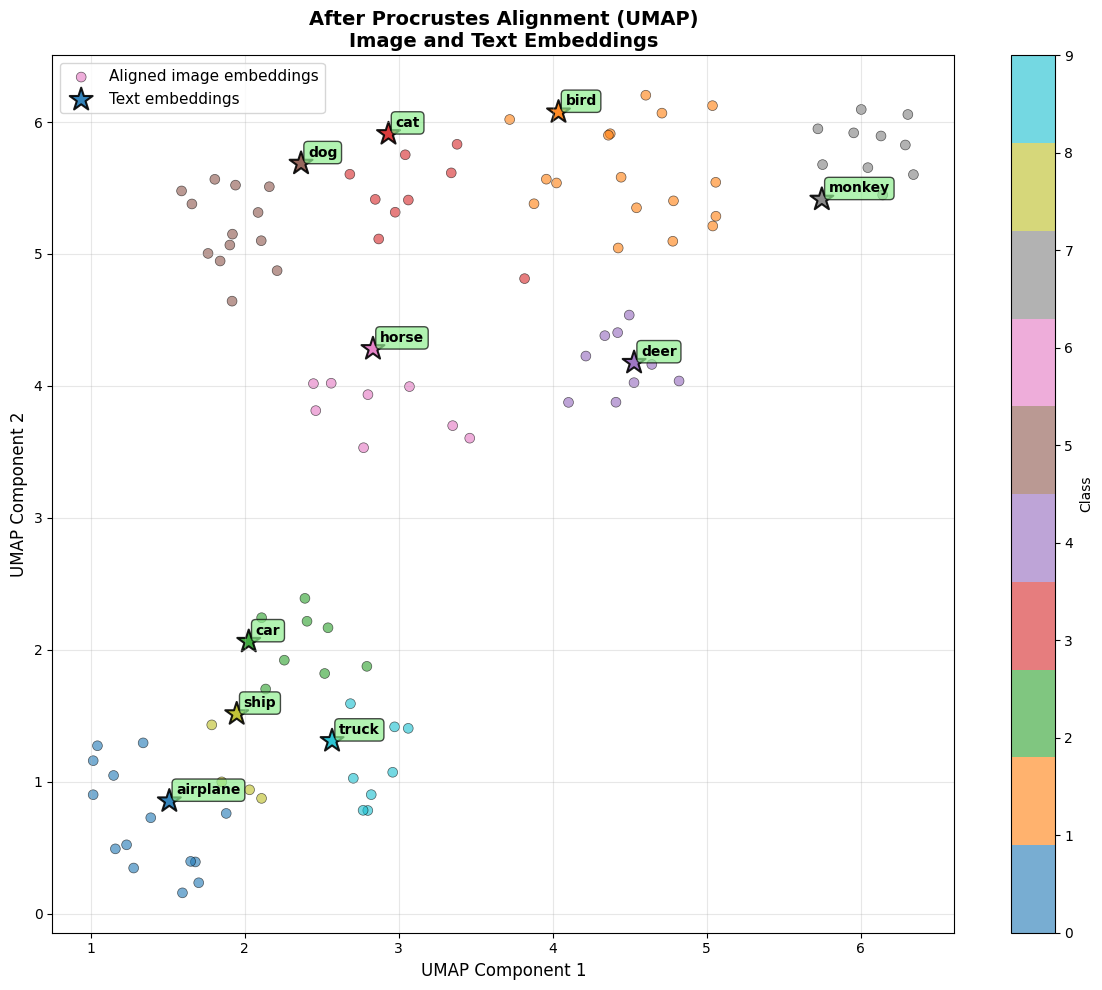


Reducing aligned embeddings to 2D using TSNE...
Saved: aligned_embeddings_tsne.png


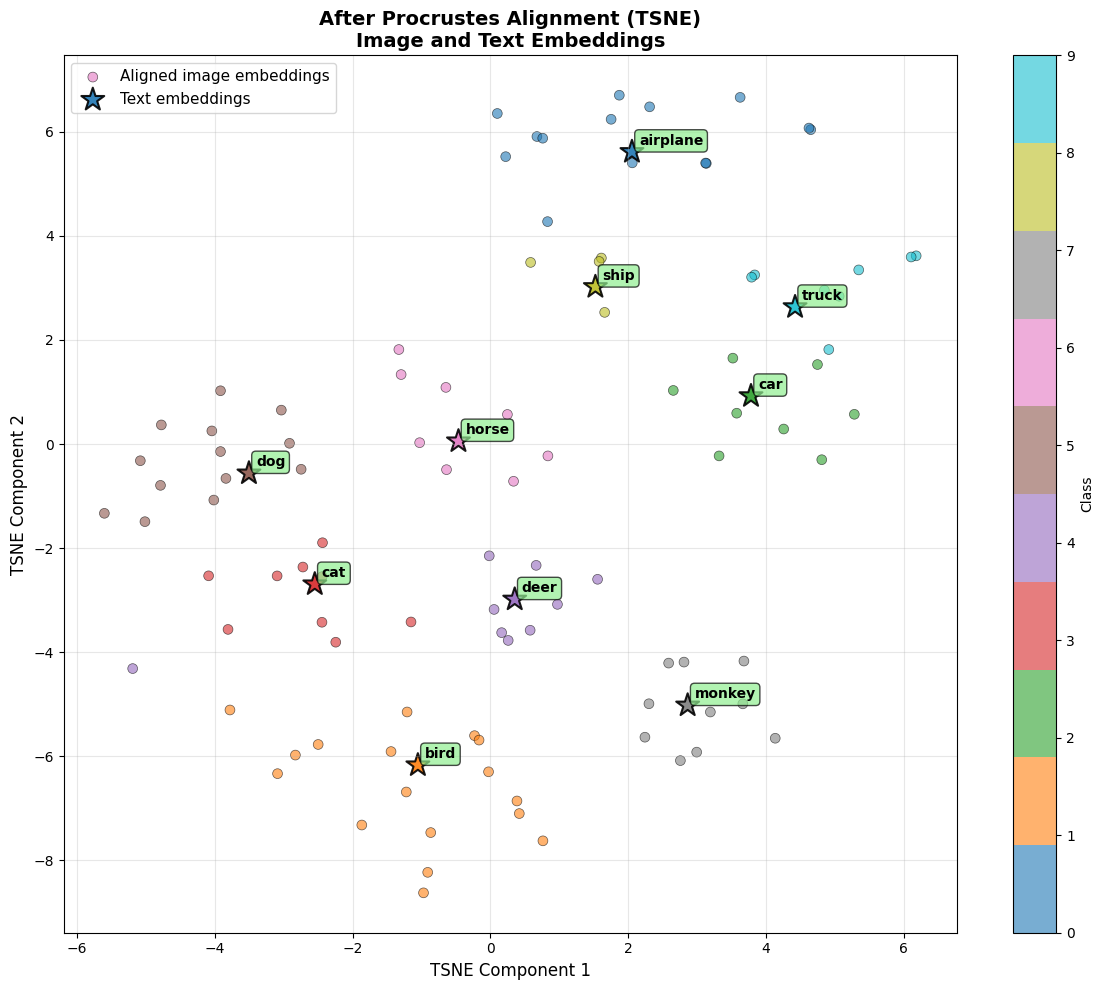

In [21]:
# e). visualize the align embeddings with t-SNE or UMAP
def visualize_aligned_embeddings(image_aligned, text_embeddings, labels, class_names, method='umap'):

    # combine for joint dimensionality reduction
    combined = np.vstack([image_aligned, text_embeddings])

    print(f"\nReducing aligned embeddings to 2D using {method.upper()}...")

    if method == 'tsne':
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    else:  # umap
        import umap
        reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15)

    combined_2d = reducer.fit_transform(combined)

    # Split back
    n_images = len(image_aligned)
    image_2d = combined_2d[:n_images]
    text_2d = combined_2d[n_images:]

    # plot
    plt.figure(figsize=(12, 10))

    # plot aligned image embeddings
    scatter_img = plt.scatter(image_2d[:, 0], image_2d[:, 1],
                              c=labels, cmap='tab10',
                              s=50, alpha=0.6, marker='o',
                              label='Aligned image embeddings',
                              edgecolors='black', linewidths=0.5)

    # plot text embeddings
    scatter_text = plt.scatter(text_2d[:, 0], text_2d[:, 1],
                               c=range(len(class_names)), cmap='tab10',
                               s=300, alpha=0.9, marker='*',
                               label='Text embeddings',
                               edgecolors='black', linewidths=1.5)

    # add text labels
    for i, name in enumerate(class_names):
        plt.annotate(name, (text_2d[i, 0], text_2d[i, 1]),
                    fontsize=10, fontweight='bold',
                    xytext=(5, 5), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

    plt.xlabel(f'{method.upper()} Component 1', fontsize=12)
    plt.ylabel(f'{method.upper()} Component 2', fontsize=12)
    plt.title(f'After Procrustes Alignment ({method.upper()})\nImage and Text Embeddings',
              fontsize=14, fontweight='bold')
    plt.legend(loc='best', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.colorbar(scatter_img, label='Class')
    plt.tight_layout()

    filename = f'aligned_embeddings_{method.lower()}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved: {filename}")
    plt.show()


# visualize aligned embeddings with UMAP
visualize_aligned_embeddings(image_embeddings_aligned, text_embeddings,
                            labels, class_names, method='umap')

# visualize aligned embeddings with t-SNE
visualize_aligned_embeddings(image_embeddings_aligned, text_embeddings,
                            labels, class_names, method='tsne')


COMPARING CLASSIFICATION ACCURACY

Evaluating with ALIGNED embeddings...


Evaluating with alignment: 100%|██████████| 125/125 [19:52<00:00,  9.54s/it]



FINAL COMPARISON
Original CLIP (no alignment):      97.26%
After Procrustes Alignment:        97.11%
Difference:                        -0.15%

Saved: alignment_accuracy_comparison.png


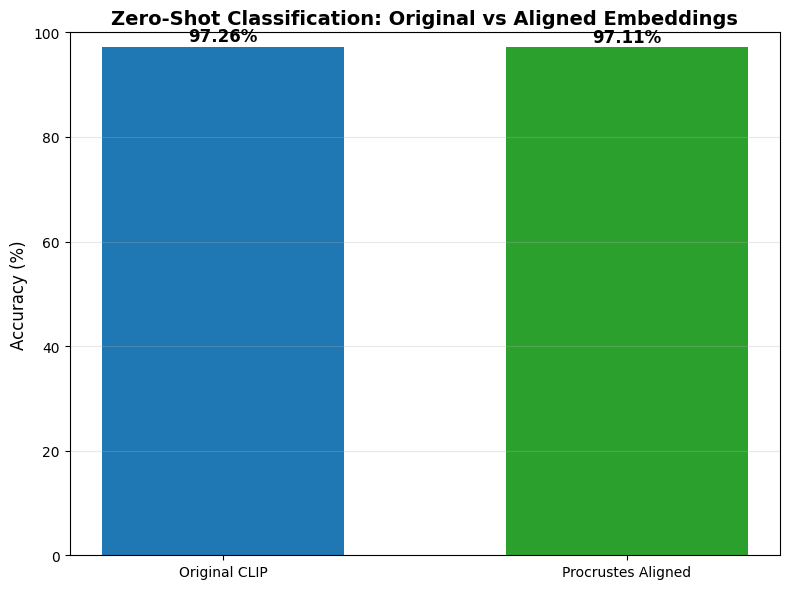


OBSERVATIONS:
✗ Alignment DECREASED classification accuracy
  Reason: CLIP's original embedding space is already optimized
  Procrustes assumes linear alignment, but CLIP uses contrastive learning


In [22]:
# f) ecompute classification accuracy with aligned embeddings
def evaluate_with_aligned_embeddings(model, dataloader, text_embeddings, R, class_names):
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating with alignment"):
            images = images.to(device)

            # get image features
            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

            # apply transformation
            image_features_np = image_features.cpu().numpy()
            image_features_aligned = image_features_np @ R
            image_features_aligned = torch.from_numpy(image_features_aligned).to(device)

            # normalize after rotation
            image_features_aligned = image_features_aligned / image_features_aligned.norm(dim=-1, keepdim=True)

            # convert text embeddings to tensor
            text_features = torch.from_numpy(text_embeddings).float().to(device)

            # compute similarity
            similarity = (100.0 * image_features_aligned @ text_features.T)

            # get predictions
            _, predictions = similarity.max(dim=1)

            correct += (predictions == labels.to(device)).sum().item()
            total += labels.size(0)

    accuracy = 100.0 * correct / total
    return accuracy


print("\n" + "="*70)
print("COMPARING CLASSIFICATION ACCURACY")
print("="*70)

accuracy_original = accuracy_simple  # From Part 4.1

# evaluate with aligned embeddings
print("\nEvaluating with ALIGNED embeddings...")
accuracy_aligned = evaluate_with_aligned_embeddings(model, test_loader,
                                                    text_embeddings, R, class_names)

# comparison
print("\n" + "="*70)
print("FINAL COMPARISON")
print("="*70)
print(f"Original CLIP (no alignment):      {accuracy_original:.2f}%")
print(f"After Procrustes Alignment:        {accuracy_aligned:.2f}%")
print(f"Difference:                        {accuracy_aligned - accuracy_original:+.2f}%")
print("="*70)

# visualize comparison
plt.figure(figsize=(8, 6))
methods = ['Original CLIP', 'Procrustes Aligned']
accuracies = [accuracy_original, accuracy_aligned]

bars = plt.bar(methods, accuracies, color=['#1f77b4', '#2ca02c'], width=0.6)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Zero-Shot Classification: Original vs Aligned Embeddings',
          fontsize=14, fontweight='bold')
plt.ylim([0, 100])

# add value labels
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc:.2f}%', ha='center', fontsize=12, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('alignment_accuracy_comparison.png', dpi=300, bbox_inches='tight')
print("\nSaved: alignment_accuracy_comparison.png")
plt.show()

print("\nOBSERVATIONS:")
if accuracy_aligned > accuracy_original:
    print(" ✓ Alignment INCREASED classification accuracy")
    print("  Reason: Better alignment between image and text modalities")
elif accuracy_aligned < accuracy_original:
    print("✗ Alignment DECREASED classification accuracy")
    print("  Reason: CLIP's original embedding space is already optimized")
    print("  Procrustes assumes linear alignment, but CLIP uses contrastive learning")
else:
    print("= Alignment had NO significant effect")
    print("  Reason: Original embeddings already well-aligned")
